In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex

HOME_DIR = os.getcwd()

In [2]:
def extract_probabilities(workload_str): 
    pattern = r"=\s*([-+]?\d*\.\d+|\d+)"
    return [float(num) for num in re.findall(pattern, workload_str)]

In [3]:
os.chdir(HOME_DIR)
os.chdir("../experiment_results/rho_multiples") 
files = [#'uniform.csv', 
         #'unimodal_1.csv', 'unimodal_2.csv', 'unimodal_3.csv', 'unimodal_4.csv', 
         #'bimodal_1.csv', 'bimodal_2.csv', 'bimodal_3.csv', 'bimodal_4.csv', 'bimodal_5.csv', 'bimodal_6.csv',
         'trimodal_1.csv', 'trimodal_2.csv', 'trimodal_3.csv', 'trimodal_4.csv'
        ]

## Plots With Error Bars

Ran each trial $5$ times. 

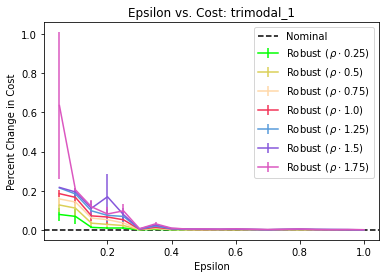

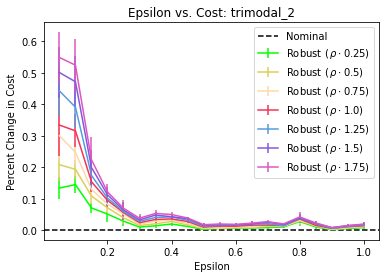

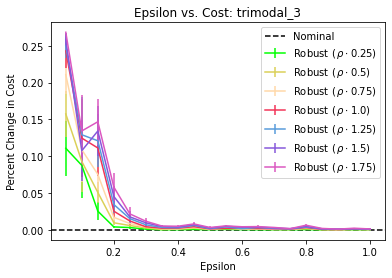

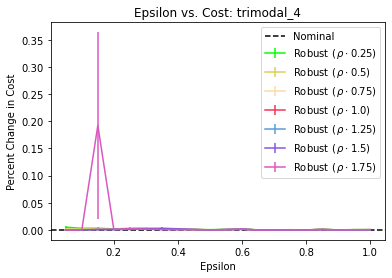

In [4]:
palette = sns.color_palette("hls", 7)
palette[3] = (0.95, 0.2, 0.34)
palette[0] = (0.0, 1.0, 0.0)
palette[2] = (1.0, 0.847, 0.659)

for file_num in range(len(files)): 
    df = pd.read_csv(files[file_num])
    df['Percent Change'] = (df['Robust Cost'] - df['Nominal Cost'])/df['Nominal Cost']
    percent_change = df.groupby(['Epsilon', 'Rho Multiplier'])['Percent Change'].apply(np.array).reset_index()
    percent_change['mean'] = percent_change['Percent Change'].apply(lambda x: x.mean())
    percent_change['error'] = percent_change['Percent Change'].apply(lambda x: x.std()/np.sqrt(len(x)))
    
    for i, mult in enumerate(percent_change['Rho Multiplier'].unique()): 
        selection = percent_change[percent_change['Rho Multiplier'] == mult]
        plt.errorbar(selection['Epsilon'].to_numpy(), selection['mean'].to_numpy(), yerr=selection['error'].to_numpy(), label=rf'Robust ($\,\rho \cdot ${mult})', color=palette[i])

    plt.axhline(y=0, color='black', linestyle="--", label="Nominal")
    plt.legend()
    plt.xlabel('Epsilon')
    plt.ylabel('Percent Change in Cost')
    name = "Epsilon vs. Cost: " + files[file_num].split(".")[0]
    plt.title(name)
    plt.show()

I think what this tells us is our $\rho$ multiplier step size is too small, since the error bars are overlapping with one another. Maybe for our final graphs, we can just pick three: $[0.25, 1, 1.75]$. The largest error bars are for $\varepsilon \leq 0.2$, which are also the regions where differential privacy has the largest effect on increasing the robust cost. 

## Plots Without Error Bars

Each point is the average out of $5$ trials. 

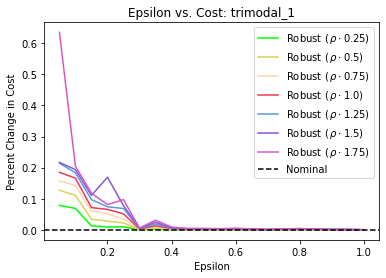

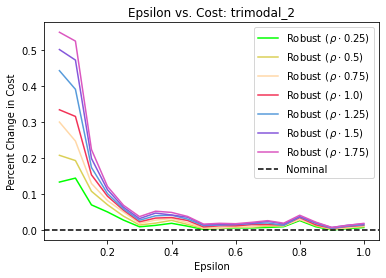

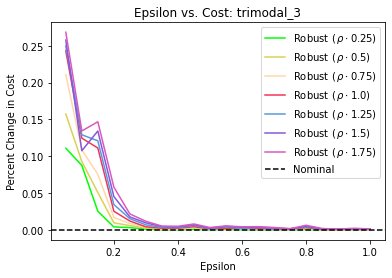

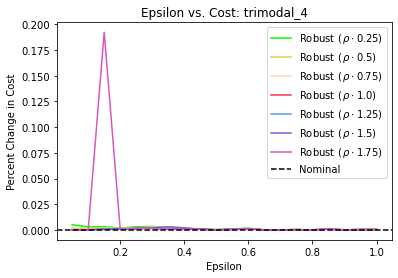

In [5]:
palette = sns.color_palette("hls", 7)
palette[3] = (0.95, 0.2, 0.34)
palette[0] = (0.0, 1.0, 0.0)
palette[2] = (1.0, 0.847, 0.659)

for file_num in range(len(files)): 
    df = pd.read_csv(files[file_num])
    df['Percent Change'] = (df['Robust Cost'] - df['Nominal Cost'])/df['Nominal Cost']
    percent_change = df.groupby(['Epsilon', 'Rho Multiplier'])['Percent Change'].apply(np.array).reset_index()
    percent_change['mean'] = percent_change['Percent Change'].apply(lambda x: x.mean())
    percent_change['error'] = percent_change['Percent Change'].apply(lambda x: x.std()/np.sqrt(len(x)))
    
    for i, mult in enumerate(percent_change['Rho Multiplier'].unique()): 
        selection = percent_change[percent_change['Rho Multiplier'] == mult]
        plt.plot(selection['Epsilon'].to_numpy(), selection['mean'].to_numpy(), label=rf'Robust ($\,\rho \cdot ${mult})', color=palette[i])

    plt.axhline(y=0, color='black', linestyle="--", label="Nominal")
    plt.legend()
    plt.xlabel('Epsilon')
    plt.ylabel('Percent Change in Cost')
    name = "Epsilon vs. Cost: " + files[file_num].split(".")[0]
    plt.title(name)
    plt.show()